In [1]:
library(rethinking)

Loading required package: rstan
Warning message:
"package 'rstan' was built under R version 3.3.2"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.2"Loading required package: StanHeaders
Warning message:
"package 'StanHeaders' was built under R version 3.3.2"rstan (Version 2.13.2, packaged: 2016-12-18 07:04:42 UTC, GitRev: 5fa1e80eb817)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
Loading required package: parallel
rethinking (Version 1.59)


In [51]:
data(tulips)

In [52]:
d<- tulips

In [83]:
d$bed.b <- ifelse( d$bed=="b" , 1 , 0 )
d$bed.c <- ifelse( d$bed=="c" , 1 , 0 )
#d$bed.a <- ifelse( d$bed=="a" , 1 , 0 )

In [54]:
d$shade.c <- d$shade - mean(d$shade)
d$water.c <- d$water - mean(d$water)

In [109]:
m7.9 <- map(
    alist(
        blooms ~ dnorm( mu , sigma ) ,
        mu <- a + bW*water.c + bS*shade.c + bWS*water.c*shade.c + bb*bed.b + bc*bed.c,
        a ~ dnorm( 130 , 100 ) ,
        bW ~ dnorm( 0 , 100 ) ,
        bS ~ dnorm( 0 , 100 ) ,
        bWS ~ dnorm( 0 , 100 ) ,
        bb ~ dnorm( 0 , 100 ) ,
        bc ~ dnorm( 0 , 100 ) ,
        sigma ~ dunif( 0 , 100 )
    ) ,
    data=d ,
    start=list(a=mean(d$blooms),bW=0,bS=0,bWS=0,bb=0,bc=0,sigma=sd(d$blooms)) )

In [110]:
precis(m7.9)
#bed a is in the intercept

        Mean StdDev   5.5%  94.5%
a      99.36  12.76  78.97 119.75
bW     75.12   9.20  60.42  89.83
bS    -41.23   9.20 -55.93 -26.53
bWS   -52.15  11.24 -70.12 -34.18
bb     42.41  18.04  13.58  71.24
bc     47.03  18.04  18.20  75.86
sigma  39.19   5.34  30.66  47.72

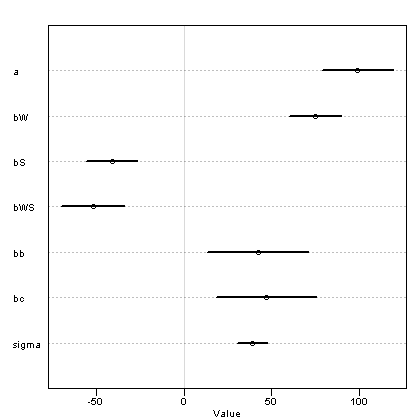

In [111]:
options(repr.plot.res = 60)
plot(precis(m7.9))

In [112]:
d$bed_idx <- coerce_index( d$bed )

In [113]:
m2 <- map(
alist(
    blooms ~ dnorm(mu,sigma),
    mu <- a[bed_idx] + bW*water.c + bS*shade.c + bWS*water.c*shade.c ,
    a[bed_idx] ~ dnorm(100,10),#dnorm(130,100) 100 doesnt converge
    c(bW,bS,bWS) ~ dnorm(0,100),
    sigma ~ dunif(0,100)
),
start=list(a=rep(130,3),bW=0,bS=0,bWS=0,sigma=90),
data=d )
precis(m2,depth=2)

        Mean StdDev   5.5%  94.5%
a[1]   99.17   8.44  85.69 112.66
a[2]  112.28   8.83  98.16 126.40
a[3]  113.64   8.92  99.37 127.90
bW     74.88  11.04  57.23  92.52
bS    -41.10  11.04 -58.74 -23.45
bWS   -51.89  13.48 -73.44 -30.35
sigma  47.12   7.08  35.81  58.43

In [115]:
#differenc between b vs c
post <- extract.samples(m2)
diff_b_c <- post$a[,2] - post$a[,3]
HPDI( diff_b_c )
mean(diff_b_c)

|0.89     0.89| 
-19.64405  18.35539

[1] -1.531192

In [8]:
m7.9a <- map(
    alist(
        blooms ~ dnorm( mu , sigma ) ,
        mu <- a + bW*water.c + bS*shade.c + bWS*water.c*shade.c ,
        a ~ dnorm( 130 , 100 ) ,
        bW ~ dnorm( 0 , 100 ) ,
        bS ~ dnorm( 0 , 100 ) ,
        bWS ~ dnorm( 0 , 100 ) ,
        sigma ~ dunif( 0 , 100 )
    ) ,
    data=d ,
    start=list(a=mean(d$blooms),bW=0,bS=0,bWS=0,sigma=sd(d$blooms)) )

In [9]:
compare(m7.9,m7.9a)

       WAIC pWAIC dWAIC weight    SE  dSE
m7.9  295.3  10.0     0   0.62 10.09   NA
m7.9a 296.3   6.7     1   0.38 10.38 8.13

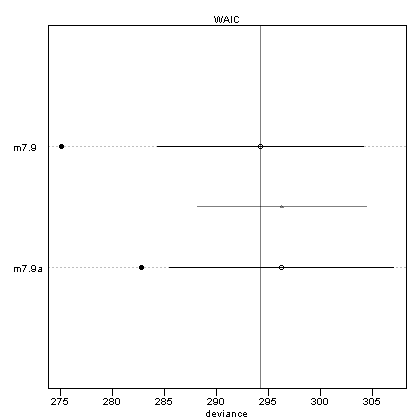

In [117]:
#par(mfrow = c(2,2))
plot(compare(m7.9,m7.9a) )

In [122]:
post <- extract.samples( m7.9 )

In [123]:
coeftab(m7.9 )

      m7.9   
a       99.36
bW      75.12
bS     -41.23
bWS    -52.15
bb      42.41
bc      47.03
sigma   39.19
nobs       27

In [125]:
HPDI(post$bc, prob=c(.01,.5,.89) )
HPDI(post$bb, prob=c(.01,.5,.89) )

|0.89     |0.5    |0.01    0.01|     0.5|    0.89| 
19.40770 34.01130 42.45345 42.79603 57.99818 76.71358

|0.89     |0.5    |0.01    0.01|     0.5|    0.89| 
13.70637 30.63588 41.22126 41.54986 55.15959 71.09335

In [127]:
mean(post$bc)
mean(post$bb) #a lot of it is between less than 0 and above 0

[1] 47.13228

[1] 42.36992

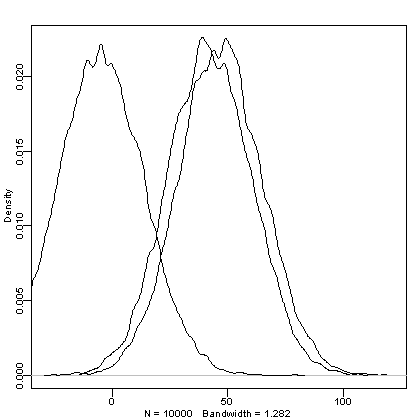

In [131]:
#par(mfrow = c(2,2))
dens(post$bc)
dens(post$bb , add= TRUE)
dens((post$bb - post$bc), add=TRUE)

In [132]:
data(rugged)
dd <- rugged

# extract countries with GDP data
dd <- dd[ complete.cases(dd$rgdppc_2000) , ]

# make log version of outcome
dd$log_gdp <- log( dd$rgdppc_2000 )

## R code 7.7
m7.5 <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + gamma*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd )

In [133]:
dd1 <-  dd[dd$country != 'Seychelles',]

## R code 7.7
m7.5b <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + gamma*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd1 )

In [136]:
compare(m7.5,m7.5b)

Warning message in compare(m7.5, m7.5b):
"Different numbers of observations found for at least two models.
Information criteria only valid for comparing models fit to exactly same observations.
Number of observations for each model:
m7.5 170 
m7.5b 169 
"Warning message in waic_ptw1 - waic_ptw2:
"longer object length is not a multiple of shorter object length"

       WAIC pWAIC dWAIC weight    SE  dSE
m7.5b 463.4   4.6   0.0   0.95 15.05   NA
m7.5  469.5   5.2   6.1   0.05 15.04 9.95

In [143]:
precis(m7.5b)
precis(m7.5)
coeftab(m7.5b,m7.5)

       Mean StdDev  5.5% 94.5%
a      9.19   0.14  8.97  9.40
bA    -1.78   0.22 -2.13 -1.43
bR    -0.19   0.08 -0.31 -0.07
bAR    0.25   0.14  0.04  0.47
sigma  0.93   0.05  0.85  1.01

       Mean StdDev  5.5% 94.5%
a      9.18   0.14  8.97  9.40
bA    -1.85   0.22 -2.20 -1.50
bR    -0.18   0.08 -0.31 -0.06
bAR    0.35   0.13  0.14  0.55
sigma  0.93   0.05  0.85  1.01

      m7.5b   m7.5   
a        9.19    9.18
bA      -1.78   -1.85
bR      -0.19   -0.18
bAR      0.25    0.35
sigma    0.93    0.93
nobs      169     170

In [20]:
# B) Plot the predictons of the interaction model, with and without Seychelles

rugged.seq <- seq(from=-1,to=8,by=0.25)

mu.Africa <- link( m7.5 , data=data.frame(cont_africa=1,rugged=rugged.seq) )
mu.Africa.mean <- apply( mu.Africa , 2 , mean )
mu.Africa.PI <- apply( mu.Africa , 2 , PI , prob=0.97 )

mu.NotAfrica <- link( m7.5 , data=data.frame(cont_africa=0,rugged=rugged.seq) )
mu.NotAfrica.mean <- apply( mu.NotAfrica , 2 , mean )
mu.NotAfrica.PI <- apply( mu.NotAfrica , 2 , PI , prob=0.97 )


[ 1000 / 1000 ]
[ 1000 / 1000 ]


In [21]:
rugged.seq <- seq(from=-1,to=8,by=0.25)

mu.Africab <- link( m7.5b , data=data.frame(cont_africa=1,rugged=rugged.seq) )
mu.Africa.meanb <- apply( mu.Africab , 2 , mean )
mu.Africa.PIb <- apply( mu.Africab , 2 , PI , prob=0.97 )

mu.NotAfricab <- link( m7.5b , data=data.frame(cont_africa=0,rugged=rugged.seq) )
mu.NotAfrica.meanb <- apply( mu.NotAfricab , 2 , mean )
mu.NotAfrica.PIb <- apply( mu.NotAfricab , 2 , PI , prob=0.97 )


[ 1000 / 1000 ]
[ 1000 / 1000 ]


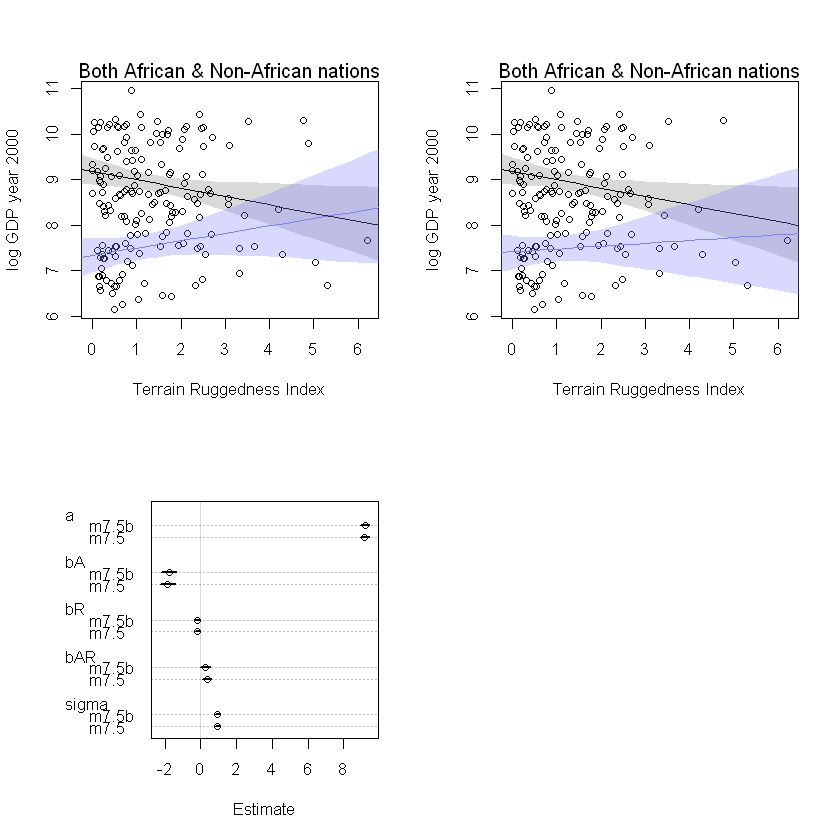

In [22]:
par(mfrow = c(2,2))

plot( log(rgdppc_2000) ~ rugged , data=dd ,
    ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations" , 3 )
lines( rugged.seq , mu.NotAfrica.mean )
shade( mu.NotAfrica.PI , rugged.seq )
lines( rugged.seq , mu.Africa.mean , col=rangi2 )
shade( mu.Africa.PI , rugged.seq , col=col.alpha(rangi2,0.3) )

plot( log(rgdppc_2000) ~ rugged , data=dd1 ,
     ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations" , 3 )
lines( rugged.seq , mu.NotAfrica.meanb )
shade( mu.NotAfrica.PIb , rugged.seq )
lines( rugged.seq , mu.Africa.meanb , col=rangi2 )
shade( mu.Africa.PIb , rugged.seq , col=col.alpha(rangi2,0.3) )

plot(coeftab(m7.5,m7.5b))

In [23]:
# c) Model comparison with WAIC. Fit  3 models to the data 1, 2 , then interaction.
# Plot the model-averaged predictions of this model set.
# Any difference with (b)? ---No? maybe tighter intervals.

In [146]:
m7H3.1 <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + bR*rugged ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        #gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
       # bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        #bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd1 )

In [147]:
m7H3.2 <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + bR*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        #gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        #bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd1 )

In [148]:
# same as m7.5b
m7H3.3 <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + gamma*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd1 )

        WAIC pWAIC dWAIC weight    SE   dSE
m7H3.3 463.7   4.8   0.0   0.78 14.96    NA
m7H3.2 466.2   4.0   2.5   0.22 14.28  3.25
m7H3.1 536.3   2.7  72.6   0.00 13.41 15.21

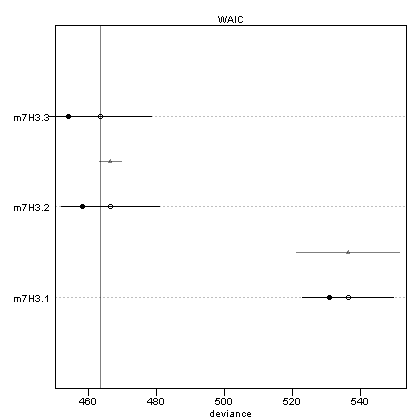

In [151]:
#Compare WAIC
#par(mfrow = c(2,2))
compare(m7H3.1,m7H3.2,m7H3.3)
plot(compare(m7H3.1,m7H3.2,m7H3.3))

In [152]:
 rugged.seq0 <- rugged.seq#seq(from =min(dd$rugged) , to=max(dd$rugged), length.out =1000 )
# d.predict <- list( log_gdp=rep(0,length(rugged.seq)) ,rugged =rugged.seq0 ,cont_africa =rep(1,length(rugged.seq)) )
# d.predict1 <- list( log_gdp=rep(0,length(rugged.seq)) ,rugged =rugged.seq0 ,cont_africa =rep(0,length(rugged.seq)) )
# pred.m7H3.3 <- link( m7H3.3 ,data = data.frame(cont_africa=0,rugged=rugged.seq) )#d.predict )
# pred.mu <- apply(pred.m7H3.3, 2, mean )
# pred.PI <- apply(pred.m7H3.3, 2, PI )
# pred.m7H3.31 <- link( m7H3.3 ,data = data.frame(cont_africa=1,rugged=rugged.seq) )#d.predict1 )
# pred.mu1 <- apply(pred.m7H3.31, 2, mean )
# pred.PI1 <- apply(pred.m7H3.31, 2, PI )

[ 1000 / 1000 ]
[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


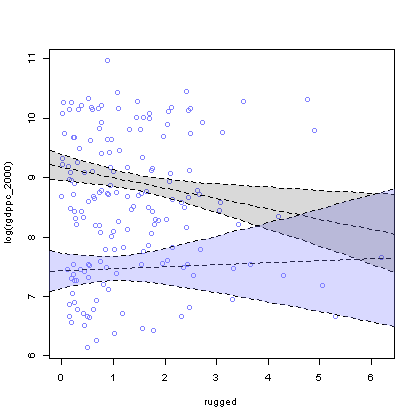

In [156]:
rugged.ensemble <-ensemble( m7H3.1, m7H3.2, m7H3.3, data=d.predict )
rug.mu <- apply( rugged.ensemble$link , 2, mean)
rug.PI <- apply( rugged.ensemble$link , 2, PI)

rugged.ensemble1 <-ensemble( m7H3.1, m7H3.2, m7H3.3, data=d.predict1 )
rug.mu1 <- apply( rugged.ensemble1$link , 2, mean)
rug.PI1 <- apply( rugged.ensemble1$link , 2, PI)

plot( log(rgdppc_2000)  ~ rugged , dd , col=rangi2 )
lines( rugged.seq0, rug.mu , lty=2 )
lines( rugged.seq0, rug.PI[1,] , lty=2 )
lines( rugged.seq0, rug.PI[2,] , lty=2 )
lines( rugged.seq0, rug.mu1 , lty=2 )
lines( rugged.seq0, rug.PI1[1,] , lty=2 )
lines( rugged.seq0, rug.PI1[2,] , lty=2 )
#ensemble shade
#lines( rugged.seq0 , rug.mu )
shade( rug.PI , rugged.seq0 ,col=col.alpha(rangi2,0.3))
#lines( rugged.seq0 , rug.mu1 )
shade( rug.PI1 , rugged.seq0 )

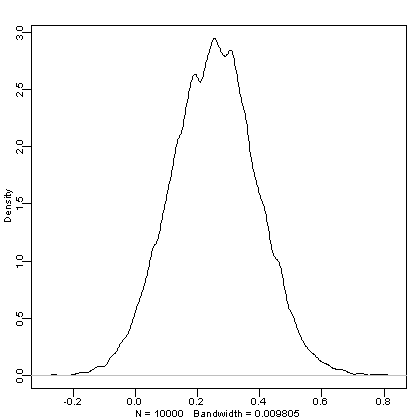

In [169]:
#Ensemble difference of rugged slopes in africa out of africa

post1 <- extract.samples(m7H3.3)
#Below bcause slope is determined within model not an explicit out put. see model from earlier.
gamma.Africa <- post1$bR + post1$bAR*1
gamma.notAfrica <- post1$bR + post1$bAR*0
diff.gama<- gamma.Africa - gamma.notAfrica
dens(diff.gama)
#beta better by .2. .2 lift

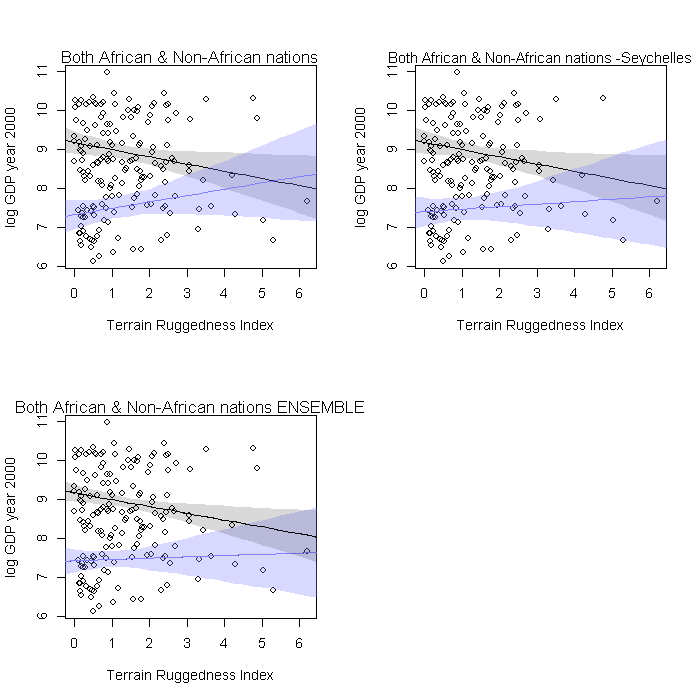

In [173]:
options(repr.plot.res = 100)
par(mfrow = c(2,2))
plot( log(rgdppc_2000) ~ rugged , data=dd ,
     ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations" , 3 )
lines( rugged.seq , mu.NotAfrica.mean )
shade( mu.NotAfrica.PI , rugged.seq )
lines( rugged.seq , mu.Africa.mean , col=rangi2 )
shade( mu.Africa.PI , rugged.seq , col=col.alpha(rangi2,0.3) )

plot( log(rgdppc_2000) ~ rugged , data=dd1 ,
     ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations -Seychelles" , 3 ,cex=.9)
lines( rugged.seq , mu.NotAfrica.meanb )
shade( mu.NotAfrica.PIb , rugged.seq )
lines( rugged.seq , mu.Africa.meanb , col=rangi2 )
shade( mu.Africa.PIb , rugged.seq , col=col.alpha(rangi2,0.3) )

#plot( log(rgdppc_2000)  ~ rugged , dd , col=rangi2 )
plot( log(rgdppc_2000) ~ rugged , data=dd ,
     ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations ENSEMBLE" , 3 )
lines( rugged.seq0, rug.mu , lty=2 )
# lines( rugged.seq0, rug.PI[1,] , lty=2 )
# lines( rugged.seq0, rug.PI[2,] , lty=2 )
lines( rugged.seq0, rug.mu1 , lty=2 )
# lines( rugged.seq0, rug.PI1[1,] , lty=2 )
# lines( rugged.seq0, rug.PI1[2,] , lty=2 )
#ensemble shade
lines( rugged.seq0 , rug.mu ,  col=rangi2 )
shade( rug.PI , rugged.seq0 ,col=col.alpha(rangi2,0.3))
lines( rugged.seq0 , rug.mu1 )
shade( rug.PI1 , rugged.seq0 )

In [174]:
# 7H4
# The values in data(nettle) are data on language diversity in 74 nations. The meaning of each column is given below.
# language diversity ~ part of food security
# langauges per captia

In [175]:
data(nettle)

In [176]:
db <- nettle

In [177]:
db$area.c <- log(db$area) - mean(log(db$area))
db$k.pop.c <- db$k.pop - mean(db$k.pop)
db$num.stations.c <- db$num.stations - mean(db$num.stations)
db$mean.growing.season.c <- db$mean.growing.season - mean(db$mean.growing.season)
db$sd.growing.season.c <- db$sd.growing.season - mean(db$sd.growing.season)

In [178]:
db$lang.per.cap <- db$num.lang/db$k.pop

In [179]:
db$lang.per.cap.log <- log(db$num.lang/db$k.pop)

In [180]:
# (A)

m7H4.a <- map(
    alist(
        lang.per.cap.log ~ dnorm(mu, sigma) , 
        mu <- a + g * mean.growing.season.c + ar * area.c , 
        a ~ dnorm( mean(lang.per.cap.log), 10),
        ar ~ dnorm(mean(db$area.c), 10) ,
        g ~ dnorm(0, 1) ,
        sigma ~ dunif(0, 10)
    ) ,
    data=db  )

In [181]:
m7H4.a


Maximum a posteriori (MAP) model fit

Formula:
lang.per.cap.log ~ dnorm(mu, sigma)
mu <- a + g * mean.growing.season.c + ar * area.c
a ~ dnorm(mean(lang.per.cap.log), 10)
ar ~ dnorm(mean(db$area.c), 10)
g ~ dnorm(0, 1)
sigma ~ dunif(0, 10)

MAP values:
         a         ar          g      sigma 
-5.4565649 -0.2020180  0.1434248  1.3893293 

Log-likelihood: -129.33 

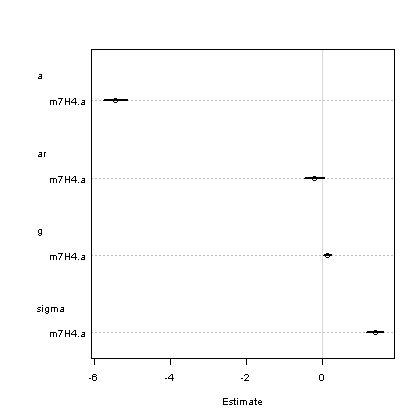

In [182]:
options(repr.plot.res = 60)
plot(coeftab(m7H4.a))

[ 1000 / 1000 ]


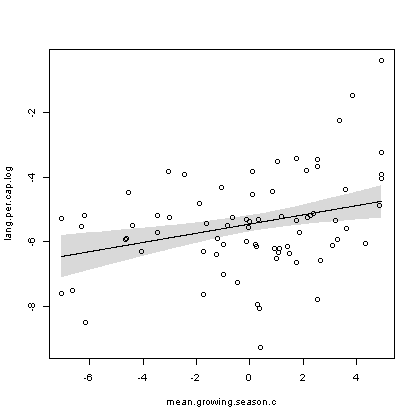

In [40]:
options(repr.plot.res = 60)
meangs.seq <- seq(from =min(db$mean.growing.season.c) , to=max(db$mean.growing.season.c), length.out =1000 )
#d.predict <- list( log_gdp=rep(0,length(rugged.seq)) ,rugged =rugged.seq0 ,cont_africa =rep(1,length(rugged.seq)) )
pred.m7H4.a <- link( m7H4.a ,data = data.frame(area.c=mean(db$area.c),mean.growing.season.c=meangs.seq) )
pred.mu <- apply(pred.m7H4.a, 2, mean )
pred.PI <- apply(pred.m7H4.a, 2, PI )

plot( lang.per.cap.log ~ mean.growing.season.c , db ) 
lines( meangs.seq , pred.mu )
shade( pred.PI , meangs.seq )

In [183]:
# (B)
m7H4.b <- map(
    alist(
        lang.per.cap.log ~ dnorm(mu, sigma) , 
        mu <- a + gsd * sd.growing.season.c + ar * area.c , 
        a ~ dnorm( mean(lang.per.cap.log), 10),
        ar ~ dnorm(mean(db$area.c), 10) ,
        gsd ~ dnorm(0, 1) ,
        sigma ~ dunif(0, 10)
    ) ,
    data=db  )
precis(m7H4.b)

       Mean StdDev  5.5% 94.5%
a     -5.46   0.17 -5.72 -5.19
ar    -0.24   0.16 -0.49  0.01
gsd   -0.20   0.18 -0.50  0.09
sigma  1.44   0.12  1.25  1.63

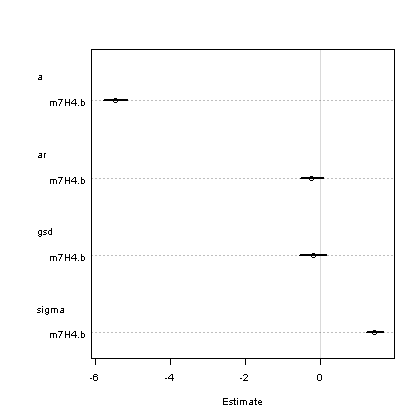

In [42]:
plot(coeftab(m7H4.b))

[ 1000 / 1000 ]


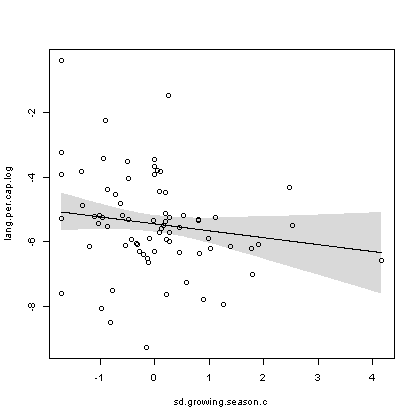

In [43]:
meangs.seqb <- seq(from =min(db$sd.growing.season.c) , to=max(db$sd.growing.season.c), length.out =1000 )
#d.predict <- list( log_gdp=rep(0,length(rugged.seq)) ,rugged =rugged.seq0 ,cont_africa =rep(1,length(rugged.seq)) )

pred.m7H4.b <- link( m7H4.b ,data = data.frame(area.c=mean(db$area.c),sd.growing.season.c=meangs.seqb) )
pred.mub <- apply(pred.m7H4.b, 2, mean )
pred.PIb <- apply(pred.m7H4.b, 2, PI )

plot( lang.per.cap.log ~ sd.growing.season.c , db ) 
lines( meangs.seqb , pred.mub )
shade( pred.PIb , meangs.seqb )

In [184]:
# (C)
m7H4.c <- map(
    alist(
        lang.per.cap.log ~ dnorm(mu, sigma) , 
        mu <- a + gsd * sd.growing.season.c + ar * area.c + g * mean.growing.season.c + ggsd *mean.growing.season.c*sd.growing.season.c , 
        a ~ dnorm( mean(lang.per.cap.log), 10),
        ar ~ dnorm(mean(db$area.c), 10) ,
        gsd ~ dnorm(0, 1) ,
        g ~ dnorm(0, 1) ,
        ggsd ~ dnorm(0, 1) ,
        sigma ~ dunif(0, 10)
    ) ,
    data=db  )
precis(m7H4.c)

       Mean StdDev  5.5% 94.5%
a     -5.45   0.15 -5.69 -5.21
ar    -0.01   0.16 -0.26  0.24
gsd   -0.33   0.17 -0.61 -0.05
g      0.11   0.06  0.02  0.21
ggsd  -0.11   0.05 -0.18 -0.03
sigma  1.31   0.11  1.14  1.48

[ 1000 / 1000 ]
[ 1000 / 1000 ]
[ 1000 / 1000 ]


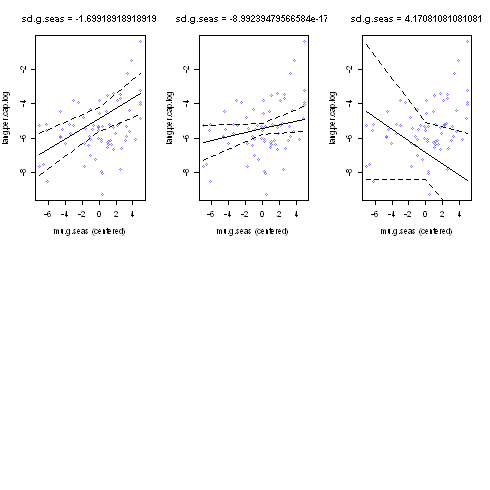

In [45]:
options(repr.plot.res = 70)

par(mfrow=c(2,3)) # 1 row, 3 columns

# loop over values of water.c and plot predictions
#shade.seq <- c(min(log(db$area)),mean(log(db$area)),max(log(db$area)))
shade.seq <- c(min(db$mean.growing.season.c),mean(db$mean.growing.season.c),max(db$mean.growing.season.c)) 

for (  w in c(min(db$sd.growing.season.c),mean(db$sd.growing.season.c),max(db$sd.growing.season.c)) ) {
    dt <- db[db$sd.growing.season.c==w,]
    plot(lang.per.cap.log ~ mean.growing.season.c , db , col=rangi2 ,
        main=paste("sd.g.seas =",w) , #xaxp=c(-1,1,2) , ylim=c(0,max(db$lang.per.cap.log)) ,
        xlab="mu.g.seas (centered)" )
    mu <- link( m7H4.c , data=data.frame(sd.growing.season.c=w,area.c=mean(db$area.c),mean.growing.season.c=shade.seq)) 
    mu.mean <- apply( mu , 2 , mean )
    mu.PI <- apply( mu , 2 , PI , prob=0.97 )
    lines( shade.seq , mu.mean )
    lines( shade.seq , mu.PI[1,] , lty=2 )
    lines( shade.seq , mu.PI[2,] , lty=2 )
    }

        WAIC pWAIC dWAIC weight    SE  dSE
m7H4.c 264.2   7.3   0.0   0.86 16.52   NA
m7H4.a 267.9   4.9   3.8   0.13 15.89 5.31
m7H4.b 273.9   5.4   9.7   0.01 17.05 6.28

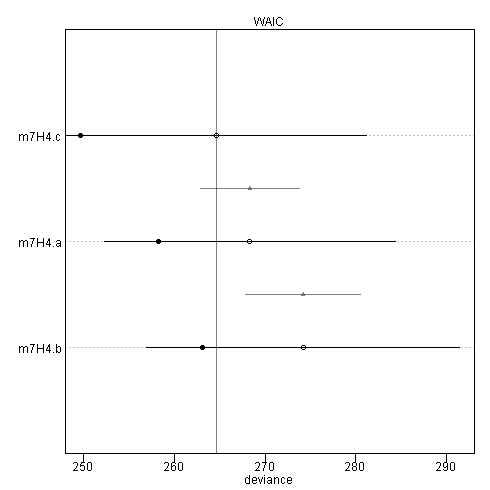

In [46]:
compare(m7H4.c,m7H4.b,m7H4.a)
plot(compare(m7H4.c,m7H4.b,m7H4.a))

      m7H4.c  m7H4.b  m7H4.a 
a       -5.45   -5.46   -5.46
ar      -0.01   -0.24   -0.20
gsd     -0.33   -0.20      NA
g        0.11      NA    0.14
ggsd    -0.11      NA      NA
sigma    1.31    1.44    1.39
nobs       74      74      74

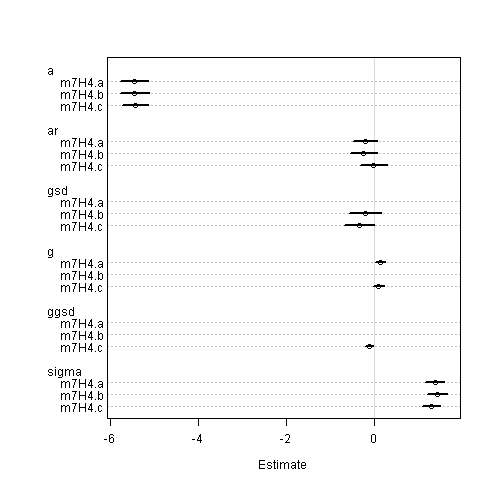

In [47]:
coeftab(m7H4.c,m7H4.b,m7H4.a)
plot(coeftab(m7H4.c,m7H4.b,m7H4.a))

[ 1000 / 1000 ]
[ 1000 / 1000 ]
[ 1000 / 1000 ]


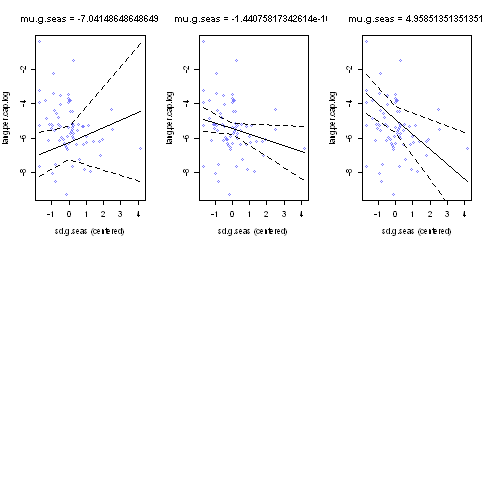

In [48]:
par(mfrow=c(2,3)) # 1 row, 3 columns
shade.seq <- c(min(db$sd.growing.season.c),mean(db$sd.growing.season.c),max(db$sd.growing.season.c)) 

for (  w in c(min(db$mean.growing.season.c),mean(db$mean.growing.season.c),max(db$mean.growing.season.c)) ) {
    dt <- db[db$mean.growing.season.c==w,]
    plot(lang.per.cap.log ~ sd.growing.season.c , db , col=rangi2 ,
        main=paste("mu.g.seas =",w) , #xaxp=c(-1,1,2) , ylim=c(0,max(db$lang.per.cap.log)) ,
        xlab="sd.g.seas (centered)" )
    mu <- link( m7H4.c , data=data.frame(mean.growing.season.c=w,area.c=mean(db$area.c),sd.growing.season.c=shade.seq)) 
    mu.mean <- apply( mu , 2 , mean )
    mu.PI <- apply( mu , 2 , PI , prob=0.97 )
    lines( shade.seq , mu.mean )
    lines( shade.seq , mu.PI[1,] , lty=2 )
    lines( shade.seq , mu.PI[2,] , lty=2 )
    }

In [ ]:
# Conclusion interactions works both ways. 
# how does a affect b and b affect a same interaction a*b . Plot both directions...
# according to the model mean growing season increases language diversity until the variance is too high.
# same in the other direction variance in growing season decreases language
# diversity, unless the mean growing season is very short (bottom row).